In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn.objects as so
from scipy import stats
import koreanize_matplotlib
koreanize_matplotlib.koreanize()

In [2]:
# 데이터 로드
train = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\train.csv')
test = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\test.csv')
submission = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (630000, 13)
Test shape: (270000, 12)


In [3]:
# 데이터 기본 정보 확인
print("Train columns:", train.columns.tolist())
print("\nData types:")
print(train.dtypes)

Train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

Data types:
id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object


In [4]:
# 수치형/명목형 변수 분리
numeric_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
categorical_cols = ['gender', 'course', 'sleep_quality', 'study_method', 
                    'facility_rating', 'exam_difficulty', 'internet_access']

print("수치형 변수:", numeric_cols)
print("명목형 변수:", categorical_cols)

수치형 변수: ['age', 'study_hours', 'class_attendance', 'sleep_hours']
명목형 변수: ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'internet_access']


## 1. 순서형 변수 수치 변환

EDA 분석 결과를 기반으로 순서가 있는 범주형 변수들을 수치로 변환한다.
- sleep_quality: poor(1) < average(2) < good(3)
- facility_rating: low(1) < medium(2) < high(3)
- exam_difficulty: easy(1) < moderate(2) < hard(3)

In [5]:
# 순서형 변수를 수치로 변환하는 함수
def encode_ordinal_features(df):
    df = df.copy()
    
    # 순서형 변수 매핑
    sleep_map = {'poor': 1, 'average': 2, 'good': 3}
    facility_map = {'low': 1, 'medium': 2, 'high': 3}
    difficulty_map = {'easy': 1, 'moderate': 2, 'hard': 3}
    
    df['sleep_quality_num'] = df['sleep_quality'].map(sleep_map)
    df['facility_num'] = df['facility_rating'].map(facility_map)
    df['difficulty_num'] = df['exam_difficulty'].map(difficulty_map)
    
    return df

train = encode_ordinal_features(train)
test = encode_ordinal_features(test)

print("순서형 변수 인코딩 완료")
print(train[['sleep_quality', 'sleep_quality_num', 'facility_rating', 'facility_num']].head())

순서형 변수 인코딩 완료
  sleep_quality  sleep_quality_num facility_rating  facility_num
0       average                  2             low             1
1          poor                  1          medium             2
2          poor                  1            high             3
3       average                  2            high             3
4          good                  3            high             3


## 2. 파생변수 생성

EDA 결과 기반으로 의미있는 파생변수를 생성한다:
- study_hours (상관 0.77), class_attendance (상관 0.35)가 핵심 변수
- sleep_quality, study_method, facility_rating이 중요한 범주형 변수
- 이들의 상호작용과 비선형 변환을 통해 파생변수 생성

In [6]:
# 파생변수 생성 함수 - 학습 효율성 관련
def create_efficiency_features(df):
    df = df.copy()
    
    # 공부 효율성: 수면의 질에 따라 조정된 공부 시간
    df['study_quality_adj'] = df['study_hours'] * (df['sleep_quality_num'] / 3)
    
    # 시설 기반 공부 효율
    df['study_facility_adj'] = df['study_hours'] * (df['facility_num'] / 3)
    
    # 출석-수면 시너지
    df['attendance_sleep_synergy'] = (df['class_attendance'] / 100) * df['sleep_quality_num']
    
    # 깨어있는 시간 대비 공부 비율
    df['waking_study_ratio'] = df['study_hours'] / (24 - df['sleep_hours'] + 0.1)
    
    # 공부-수면 비율
    df['study_sleep_ratio'] = df['study_hours'] / (df['sleep_hours'] + 0.1)
    
    return df

train = create_efficiency_features(train)
test = create_efficiency_features(test)

print("효율성 관련 파생변수 생성 완료")
print(train[['study_quality_adj', 'study_facility_adj', 'attendance_sleep_synergy']].describe())

효율성 관련 파생변수 생성 완료
       study_quality_adj  study_facility_adj  attendance_sleep_synergy
count      630000.000000       630000.000000             630000.000000
mean            2.700385            2.668897                  1.439413
std             2.068758            2.028968                  0.701467
min             0.026667            0.026667                  0.406000
25%             1.020000            1.033333                  0.850000
50%             2.183333            2.173333                  1.366000
75%             4.126667            4.030000                  1.924000
max             7.910000            7.910000                  2.982000


In [7]:
# 파생변수 생성 함수 - 시험 난이도 조정
def create_difficulty_features(df):
    df = df.copy()
    
    # 난이도 대비 준비도
    df['prep_vs_difficulty'] = df['study_hours'] / (df['difficulty_num'] + 0.5)
    
    # 출석률 대비 난이도
    df['attendance_vs_difficulty'] = df['class_attendance'] / (df['difficulty_num'] * 33.3 + 1)
    
    # 총 투자 시간 (공부 + 수면)
    df['total_investment'] = df['study_hours'] + df['sleep_hours']
    
    # 난이도와 시설의 상호작용
    df['difficulty_facility_gap'] = df['facility_num'] - df['difficulty_num']
    
    return df

train = create_difficulty_features(train)
test = create_difficulty_features(test)

print("난이도 관련 파생변수 생성 완료")

난이도 관련 파생변수 생성 완료


In [8]:
# 파생변수 생성 함수 - 비선형 변환
def create_nonlinear_features(df):
    df = df.copy()
    
    # 로그 변환
    df['study_log'] = np.log1p(df['study_hours'])
    
    # 제곱근 변환
    df['study_sqrt'] = np.sqrt(df['study_hours'])
    df['attendance_sqrt'] = np.sqrt(df['class_attendance'])
    
    # 제곱 변환 (수확체감/체증 효과)
    df['study_sq'] = df['study_hours'] ** 2
    
    # 최적 수면 거리 (7-8시간 기준)
    df['sleep_optimal_dist'] = np.minimum(abs(df['sleep_hours'] - 7), abs(df['sleep_hours'] - 8))
    
    # 공부 최적 거리 (5시간 기준)
    df['study_optimal_dist'] = abs(df['study_hours'] - 5)
    
    return df

train = create_nonlinear_features(train)
test = create_nonlinear_features(test)

print("비선형 변환 파생변수 생성 완료")

비선형 변환 파생변수 생성 완료


In [9]:
# 파생변수 생성 함수 - 학생 유형 분류
def create_student_type_features(df):
    df = df.copy()
    
    # 성실형 학생 (높은 공부시간 + 높은 출석률)
    df['diligent_type'] = ((df['study_hours'] > 5) & (df['class_attendance'] > 85)).astype(int)
    
    # 벼락치기형 학생 (높은 공부시간 + 적은 수면)
    df['cramming_type'] = ((df['study_hours'] > 6) & (df['sleep_hours'] < 6)).astype(int)
    
    # 효율형 학생 (적절한 수면 + 좋은 시설)
    df['efficient_type'] = ((df['sleep_quality_num'] == 3) & (df['facility_num'] >= 2)).astype(int)
    
    # 출석률 구간
    df['attendance_low'] = (df['class_attendance'] < 70).astype(int)
    df['attendance_high'] = (df['class_attendance'] >= 90).astype(int)
    
    # 수면 부족/과다 플래그
    df['sleep_deficit'] = np.maximum(0, 7 - df['sleep_hours'])
    df['sleep_excess'] = np.maximum(0, df['sleep_hours'] - 8)
    
    return df

train = create_student_type_features(train)
test = create_student_type_features(test)

print("학생 유형 파생변수 생성 완료")
print(f"성실형 학생 비율: {train['diligent_type'].mean()*100:.2f}%")
print(f"벼락치기형 학생 비율: {train['cramming_type'].mean()*100:.2f}%")

학생 유형 파생변수 생성 완료
성실형 학생 비율: 11.74%
벼락치기형 학생 비율: 7.48%


In [10]:
# 파생변수 생성 함수 - 복합 상호작용
def create_interaction_features(df):
    df = df.copy()
    
    # 3가지 핵심 요소의 조합: 공부 x 출석 x 수면질
    df['triple_factor'] = (df['study_hours'] / 10) * (df['class_attendance'] / 100) * (df['sleep_quality_num'] / 3)
    
    # 공부와 출석의 시너지
    df['study_attendance_synergy'] = (df['study_hours'] / 10) * (df['class_attendance'] / 100)
    
    # 수면 품질과 공부 효과
    df['sleep_study_product'] = df['sleep_quality_num'] * df['study_hours']
    
    # 전체 학습 환경 점수
    df['learning_env_score'] = (df['facility_num'] + df['sleep_quality_num']) / 6 * 100
    
    # 공부 방법별 효과 (추후 인코딩 후 사용)
    df['study_intensity'] = df['study_hours'] * df['class_attendance'] / 100
    
    return df

train = create_interaction_features(train)
test = create_interaction_features(test)

print("복합 상호작용 파생변수 생성 완료")
print(f"현재 컬럼 수: {train.shape[1]}")

복합 상호작용 파생변수 생성 완료
현재 컬럼 수: 43


## 3. 명목형 변수 인코딩

명목형 변수는 두 가지 방식으로 처리:
1. 라벨 인코딩: 랜덤포레스트 학습용
2. 타겟 인코딩: 범주별 평균 점수를 활용한 추가 피처

In [11]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

cat_cols = ['gender', 'course', 'sleep_quality', 'study_method', 
            'facility_rating', 'exam_difficulty', 'internet_access']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col + '_encoded'] = le.fit_transform(train[col])
    test[col + '_encoded'] = le.transform(test[col])
    label_encoders[col] = le

print("라벨 인코딩 완료")
print("인코딩된 컬럼:", [col + '_encoded' for col in cat_cols])

라벨 인코딩 완료
인코딩된 컬럼: ['gender_encoded', 'course_encoded', 'sleep_quality_encoded', 'study_method_encoded', 'facility_rating_encoded', 'exam_difficulty_encoded', 'internet_access_encoded']


In [12]:
# 타겟 인코딩 (범주별 평균 점수)
# 학습 데이터에서 각 범주의 평균 점수를 계산하여 test에도 적용

target_encodings = {}
for col in cat_cols:
    target_mean = train.groupby(col)['exam_score'].mean().to_dict()
    target_encodings[col] = target_mean
    
    train[col + '_target_enc'] = train[col].map(target_mean)
    test[col + '_target_enc'] = test[col].map(target_mean)

print("타겟 인코딩 완료")
print("\n범주별 평균 점수 예시 (study_method):")
print(target_encodings['study_method'])

타겟 인코딩 완료

범주별 평균 점수 예시 (study_method):
{'coaching': 69.26666547453624, 'group study': 60.53183773545025, 'mixed': 65.10173518515509, 'online videos': 59.72760654789927, 'self-study': 57.70015479177311}


In [13]:
# 생성된 모든 컬럼 확인
print(f"전체 컬럼 수: {train.shape[1]}")
print("\n컬럼 목록:")
for i, col in enumerate(train.columns):
    print(f"{i+1:2d}. {col}")

전체 컬럼 수: 57

컬럼 목록:
 1. id
 2. age
 3. gender
 4. course
 5. study_hours
 6. class_attendance
 7. internet_access
 8. sleep_hours
 9. sleep_quality
10. study_method
11. facility_rating
12. exam_difficulty
13. exam_score
14. sleep_quality_num
15. facility_num
16. difficulty_num
17. study_quality_adj
18. study_facility_adj
19. attendance_sleep_synergy
20. waking_study_ratio
21. study_sleep_ratio
22. prep_vs_difficulty
23. attendance_vs_difficulty
24. total_investment
25. difficulty_facility_gap
26. study_log
27. study_sqrt
28. attendance_sqrt
29. study_sq
30. sleep_optimal_dist
31. study_optimal_dist
32. diligent_type
33. cramming_type
34. efficient_type
35. attendance_low
36. attendance_high
37. sleep_deficit
38. sleep_excess
39. triple_factor
40. study_attendance_synergy
41. sleep_study_product
42. learning_env_score
43. study_intensity
44. gender_encoded
45. course_encoded
46. sleep_quality_encoded
47. study_method_encoded
48. facility_rating_encoded
49. exam_difficulty_encoded
50. in

## 4. 피처 선택 및 데이터 준비

수치형 변수와 인코딩된 명목형 변수를 결합하여 최종 피처셋 구성

In [14]:
# 피처 컬럼 정의: 원본 명목형 및 id, exam_score 제외
exclude_cols = ['id', 'exam_score'] + cat_cols

feature_cols = [col for col in train.columns if col not in exclude_cols]

print(f"사용할 피처 수: {len(feature_cols)}")
print("\n피처 목록:")
for i, col in enumerate(feature_cols):
    print(f"{i+1:2d}. {col}")

사용할 피처 수: 48

피처 목록:
 1. age
 2. study_hours
 3. class_attendance
 4. sleep_hours
 5. sleep_quality_num
 6. facility_num
 7. difficulty_num
 8. study_quality_adj
 9. study_facility_adj
10. attendance_sleep_synergy
11. waking_study_ratio
12. study_sleep_ratio
13. prep_vs_difficulty
14. attendance_vs_difficulty
15. total_investment
16. difficulty_facility_gap
17. study_log
18. study_sqrt
19. attendance_sqrt
20. study_sq
21. sleep_optimal_dist
22. study_optimal_dist
23. diligent_type
24. cramming_type
25. efficient_type
26. attendance_low
27. attendance_high
28. sleep_deficit
29. sleep_excess
30. triple_factor
31. study_attendance_synergy
32. sleep_study_product
33. learning_env_score
34. study_intensity
35. gender_encoded
36. course_encoded
37. sleep_quality_encoded
38. study_method_encoded
39. facility_rating_encoded
40. exam_difficulty_encoded
41. internet_access_encoded
42. gender_target_enc
43. course_target_enc
44. sleep_quality_target_enc
45. study_method_target_enc
46. facility_ra

In [15]:
# X, y 분리
X = train[feature_cols]
y = train['exam_score']
X_test = test[feature_cols]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

X shape: (630000, 48)
y shape: (630000,)
X_test shape: (270000, 48)


## 5. 랜덤포레스트 모델 학습 (K-Fold 교차검증)

In [16]:
# 필요 라이브러리 임포트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [17]:
# 기본 랜덤포레스트 모델로 교차검증 수행
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 결과 저장용
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
fold_scores = []

# 기본 하이퍼파라미터
rf_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'n_jobs': -1,
    'random_state': 42
}

print(f"K-Fold 교차검증 시작 (n_splits={n_splits})")
print(f"하이퍼파라미터: {rf_params}")

K-Fold 교차검증 시작 (n_splits=5)
하이퍼파라미터: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42}


In [18]:
# K-Fold 교차검증 실행
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # 모델 학습
    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    
    # 검증 예측
    valid_pred = model.predict(X_valid)
    oof_preds[valid_idx] = valid_pred
    
    # 테스트 예측 (평균)
    test_preds += model.predict(X_test) / n_splits
    
    # 성능 계산
    fold_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    fold_scores.append(fold_rmse)
    
    print(f"Fold {fold+1}: RMSE = {fold_rmse:.4f}")

Fold 1: RMSE = 8.8583
Fold 2: RMSE = 8.8620
Fold 3: RMSE = 8.8548
Fold 4: RMSE = 8.8643
Fold 5: RMSE = 8.8901


In [19]:
# 전체 성능 평가
cv_rmse = np.sqrt(mean_squared_error(y, oof_preds))
cv_mae = mean_absolute_error(y, oof_preds)
cv_r2 = r2_score(y, oof_preds)

print("\n" + "="*50)
print("기본 RandomForest CV 성능")
print("="*50)
print(f"CV RMSE: {cv_rmse:.4f}")
print(f"CV MAE:  {cv_mae:.4f}")
print(f"CV R2:   {cv_r2:.4f}")
print(f"\n평균 Fold RMSE: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")


기본 RandomForest CV 성능
CV RMSE: 8.8659
CV MAE:  7.0756
CV R2:   0.7803

평균 Fold RMSE: 8.8659 (+/- 0.0125)


In [20]:
# Feature Importance 확인
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Feature Importance:")
print(importance_df.head(20).to_string(index=False))

Top 20 Feature Importance:
                 feature  importance
study_attendance_synergy    0.133260
         study_intensity    0.104769
      waking_study_ratio    0.084594
           triple_factor    0.079482
                study_sq    0.066043
               study_log    0.064994
              study_sqrt    0.062110
             study_hours    0.055318
     sleep_study_product    0.054641
       study_quality_adj    0.039982
      study_facility_adj    0.025848
      prep_vs_difficulty    0.022345
 study_method_target_enc    0.018949
attendance_sleep_synergy    0.018496
        class_attendance    0.017321
        total_investment    0.016834
    study_method_encoded    0.015615
         attendance_sqrt    0.015072
      learning_env_score    0.013303
       study_sleep_ratio    0.012832


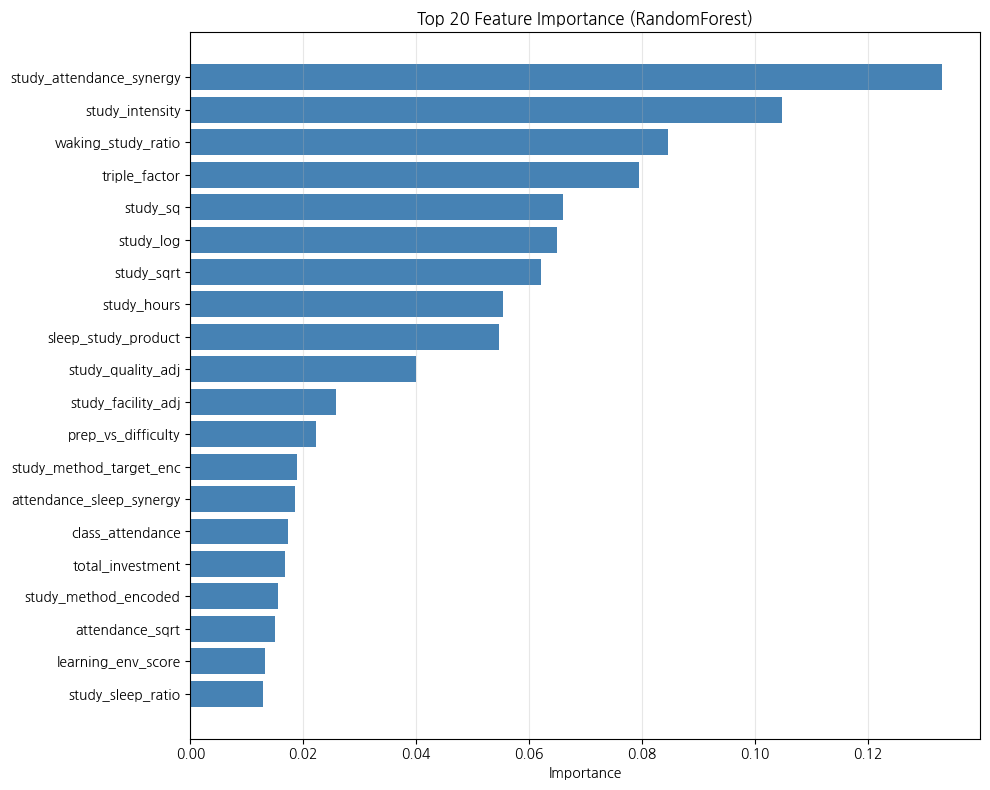

In [21]:
# Feature Importance 시각화
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 20
top_features = importance_df.head(top_n)

ax.barh(range(top_n), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance (RandomForest)')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 하이퍼파라미터 튜닝 (GridSearchCV)

기본 모델 성능을 확인했으니, 하이퍼파라미터 튜닝을 통해 성능을 개선한다.

In [22]:
# 간소화된 파라미터 그리드 정의 (시간 단축)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

print("탐색할 파라미터 조합:")
total_combinations = 1
for key, values in param_grid.items():
    print(f"  {key}: {values}")
    total_combinations *= len(values)
print(f"\n총 조합 수: {total_combinations}")

탐색할 파라미터 조합:
  n_estimators: [200, 300]
  max_depth: [15, 20]
  min_samples_split: [5, 10]
  min_samples_leaf: [2, 4]

총 조합 수: 16


In [23]:
# 데이터 샘플링 (GridSearch 속도를 위해)
# 전체 데이터의 30%만 사용하여 최적 파라미터 탐색
from sklearn.model_selection import train_test_split

X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.3, random_state=42)
print(f"GridSearch용 샘플 크기: {X_sample.shape[0]}")

GridSearch용 샘플 크기: 189000


In [24]:
# GridSearchCV 실행
rf_base = RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV 실행 중...")
grid_search.fit(X_sample, y_sample)

print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최적 CV RMSE: {-grid_search.best_score_:.4f}")

GridSearchCV 실행 중...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

최적 파라미터: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
최적 CV RMSE: 8.9481


In [25]:
# 최적 파라미터로 전체 데이터 재학습
best_params = grid_search.best_params_
best_params['max_features'] = 'sqrt'
best_params['n_jobs'] = -1
best_params['random_state'] = 42

print("최적 파라미터로 전체 데이터 K-Fold 재학습...")
print(f"파라미터: {best_params}")

최적 파라미터로 전체 데이터 K-Fold 재학습...
파라미터: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42}


In [26]:
# 최적 파라미터로 K-Fold 교차검증
oof_preds_tuned = np.zeros(len(X))
test_preds_tuned = np.zeros(len(X_test))
fold_scores_tuned = []
models_tuned = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model_tuned = RandomForestRegressor(**best_params)
    model_tuned.fit(X_train, y_train)
    
    valid_pred = model_tuned.predict(X_valid)
    oof_preds_tuned[valid_idx] = valid_pred
    test_preds_tuned += model_tuned.predict(X_test) / n_splits
    
    fold_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    fold_scores_tuned.append(fold_rmse)
    models_tuned.append(model_tuned)
    
    print(f"Fold {fold+1}: RMSE = {fold_rmse:.4f}")

Fold 1: RMSE = 8.8567
Fold 2: RMSE = 8.8603
Fold 3: RMSE = 8.8533
Fold 4: RMSE = 8.8632
Fold 5: RMSE = 8.8883


In [27]:
# 튜닝 후 성능 비교
cv_rmse_tuned = np.sqrt(mean_squared_error(y, oof_preds_tuned))
cv_mae_tuned = mean_absolute_error(y, oof_preds_tuned)
cv_r2_tuned = r2_score(y, oof_preds_tuned)

print("\n" + "="*50)
print("튜닝 후 RandomForest CV 성능")
print("="*50)
print(f"CV RMSE: {cv_rmse_tuned:.4f} (이전: {cv_rmse:.4f})")
print(f"CV MAE:  {cv_mae_tuned:.4f} (이전: {cv_mae:.4f})")
print(f"CV R2:   {cv_r2_tuned:.4f} (이전: {cv_r2:.4f})")
print(f"\n평균 Fold RMSE: {np.mean(fold_scores_tuned):.4f} (+/- {np.std(fold_scores_tuned):.4f})")


튜닝 후 RandomForest CV 성능
CV RMSE: 8.8644 (이전: 8.8659)
CV MAE:  7.0744 (이전: 7.0756)
CV R2:   0.7804 (이전: 0.7803)

평균 Fold RMSE: 8.8644 (+/- 0.0124)


## 7. 피처 선택 (중요도 기반)

낮은 중요도 피처를 제거하여 모델 단순화 및 성능 개선 시도

In [28]:
# 튜닝된 모델의 Feature Importance 확인
importance_tuned = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.mean([m.feature_importances_ for m in models_tuned], axis=0)
}).sort_values('importance', ascending=False)

print("튜닝 후 Top 20 Feature Importance:")
print(importance_tuned.head(20).to_string(index=False))

튜닝 후 Top 20 Feature Importance:
                 feature  importance
study_attendance_synergy    0.128181
         study_intensity    0.113338
           triple_factor    0.085768
      waking_study_ratio    0.082932
              study_sqrt    0.063379
                study_sq    0.059324
               study_log    0.058267
             study_hours    0.055242
     sleep_study_product    0.049287
       study_quality_adj    0.036950
      study_facility_adj    0.028192
      prep_vs_difficulty    0.025474
        total_investment    0.022631
 study_method_target_enc    0.019020
attendance_sleep_synergy    0.018646
        class_attendance    0.016714
    study_method_encoded    0.015435
         attendance_sqrt    0.015162
       study_sleep_ratio    0.013417
      learning_env_score    0.012806


In [29]:
# 중요도 기준으로 상위 피처 선택
importance_threshold = 0.01
selected_features = importance_tuned[importance_tuned['importance'] >= importance_threshold]['feature'].tolist()

print(f"선택된 피처 수: {len(selected_features)} / {len(feature_cols)}")
print(f"\n선택된 피처 목록:")
for i, feat in enumerate(selected_features):
    imp = importance_tuned[importance_tuned['feature'] == feat]['importance'].values[0]
    print(f"{i+1:2d}. {feat} ({imp:.4f})")

선택된 피처 수: 21 / 48

선택된 피처 목록:
 1. study_attendance_synergy (0.1282)
 2. study_intensity (0.1133)
 3. triple_factor (0.0858)
 4. waking_study_ratio (0.0829)
 5. study_sqrt (0.0634)
 6. study_sq (0.0593)
 7. study_log (0.0583)
 8. study_hours (0.0552)
 9. sleep_study_product (0.0493)
10. study_quality_adj (0.0370)
11. study_facility_adj (0.0282)
12. prep_vs_difficulty (0.0255)
13. total_investment (0.0226)
14. study_method_target_enc (0.0190)
15. attendance_sleep_synergy (0.0186)
16. class_attendance (0.0167)
17. study_method_encoded (0.0154)
18. attendance_sqrt (0.0152)
19. study_sleep_ratio (0.0134)
20. learning_env_score (0.0128)
21. study_optimal_dist (0.0118)


In [30]:
# 선택된 피처로 재학습
X_selected = X[selected_features]
X_test_selected = X_test[selected_features]

oof_preds_selected = np.zeros(len(X))
test_preds_selected = np.zeros(len(X_test))
fold_scores_selected = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_selected)):
    X_train, X_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model_sel = RandomForestRegressor(**best_params)
    model_sel.fit(X_train, y_train)
    
    valid_pred = model_sel.predict(X_valid)
    oof_preds_selected[valid_idx] = valid_pred
    test_preds_selected += model_sel.predict(X_test_selected) / n_splits
    
    fold_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    fold_scores_selected.append(fold_rmse)
    
    print(f"Fold {fold+1}: RMSE = {fold_rmse:.4f}")

Fold 1: RMSE = 8.8481
Fold 2: RMSE = 8.8474
Fold 3: RMSE = 8.8422
Fold 4: RMSE = 8.8538
Fold 5: RMSE = 8.8785


In [31]:
# 피처 선택 후 성능 비교
cv_rmse_selected = np.sqrt(mean_squared_error(y, oof_preds_selected))
cv_mae_selected = mean_absolute_error(y, oof_preds_selected)
cv_r2_selected = r2_score(y, oof_preds_selected)

print("\n" + "="*50)
print("피처 선택 후 성능")
print("="*50)
print(f"CV RMSE: {cv_rmse_selected:.4f}")
print(f"CV MAE:  {cv_mae_selected:.4f}")
print(f"CV R2:   {cv_r2_selected:.4f}")
print(f"\n평균 Fold RMSE: {np.mean(fold_scores_selected):.4f} (+/- {np.std(fold_scores_selected):.4f})")


피처 선택 후 성능
CV RMSE: 8.8540
CV MAE:  7.0616
CV R2:   0.7809

평균 Fold RMSE: 8.8540 (+/- 0.0128)


## 8. 최종 모델 선택 및 성능 비교

In [32]:
# 모델별 성능 비교 테이블
results_comparison = pd.DataFrame({
    '모델': ['기본 RandomForest', '튜닝 RandomForest', '피처선택 RandomForest'],
    'CV RMSE': [cv_rmse, cv_rmse_tuned, cv_rmse_selected],
    'CV MAE': [cv_mae, cv_mae_tuned, cv_mae_selected],
    'CV R2': [cv_r2, cv_r2_tuned, cv_r2_selected],
    '피처 수': [len(feature_cols), len(feature_cols), len(selected_features)]
})

print("="*60)
print("모델 성능 비교")
print("="*60)
print(results_comparison.to_string(index=False))

모델 성능 비교
               모델  CV RMSE   CV MAE    CV R2  피처 수
  기본 RandomForest 8.865893 7.075554 0.780342    48
  튜닝 RandomForest 8.864363 7.074441 0.780418    48
피처선택 RandomForest 8.854009 7.061610 0.780931    21


In [33]:
# 최적 모델 선택 (RMSE가 가장 낮은 모델)
rmse_list = [cv_rmse, cv_rmse_tuned, cv_rmse_selected]
best_idx = np.argmin(rmse_list)
model_names = ['기본', '튜닝', '피처선택']

print(f"\n최적 모델: {model_names[best_idx]} RandomForest (CV RMSE: {rmse_list[best_idx]:.4f})")

# 최적 예측값 선택
if best_idx == 0:
    final_preds = test_preds
elif best_idx == 1:
    final_preds = test_preds_tuned
else:
    final_preds = test_preds_selected

print(f"최종 예측값 shape: {final_preds.shape}")


최적 모델: 피처선택 RandomForest (CV RMSE: 8.8540)
최종 예측값 shape: (270000,)


## 9. 예측 결과 분석

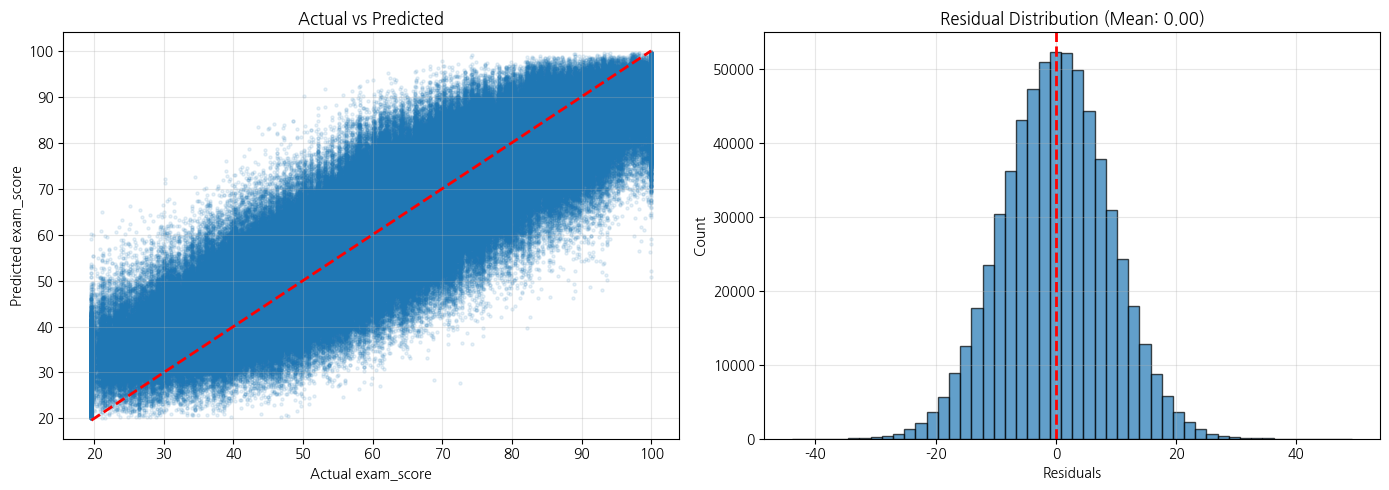

In [34]:
# OOF 예측 vs 실제값 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 예측 vs 실제 산점도
if best_idx == 0:
    oof_best = oof_preds
elif best_idx == 1:
    oof_best = oof_preds_tuned
else:
    oof_best = oof_preds_selected

axes[0].scatter(y, oof_best, alpha=0.1, s=5)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual exam_score')
axes[0].set_ylabel('Predicted exam_score')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(alpha=0.3)

# 잔차 분포
residuals = y - oof_best
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Residual Distribution (Mean: {residuals.mean():.2f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

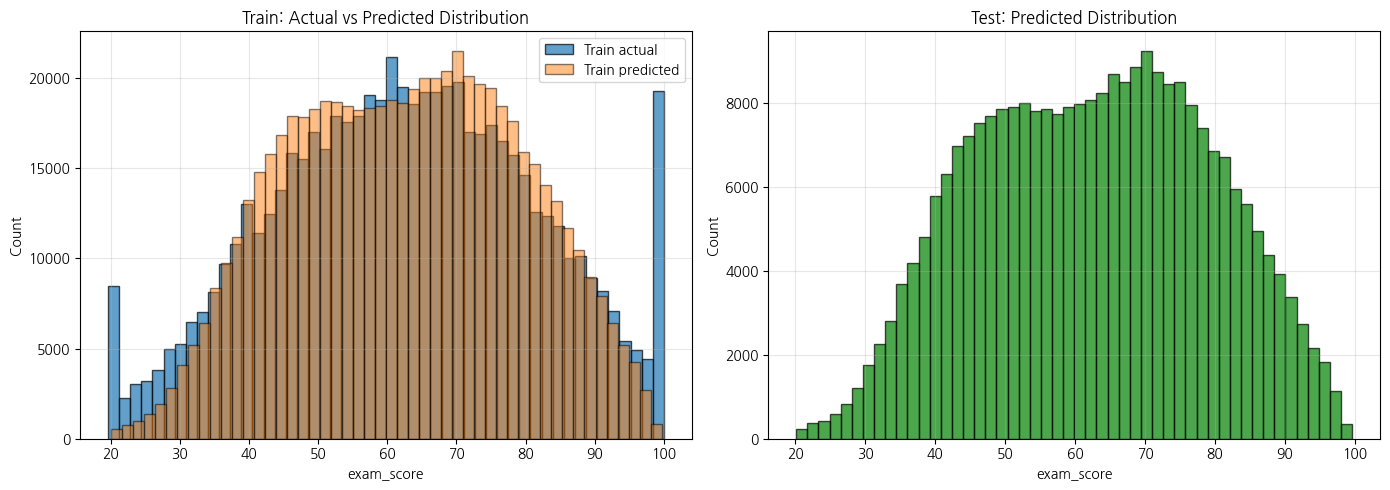

Test 예측값 통계:
  Min: 20.11
  Max: 99.64
  Mean: 62.51
  Std: 16.61


In [35]:
# 예측값 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y, bins=50, alpha=0.7, label='Train actual', edgecolor='black')
axes[0].hist(oof_best, bins=50, alpha=0.5, label='Train predicted', edgecolor='black')
axes[0].set_xlabel('exam_score')
axes[0].set_ylabel('Count')
axes[0].set_title('Train: Actual vs Predicted Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(final_preds, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].set_xlabel('exam_score')
axes[1].set_ylabel('Count')
axes[1].set_title('Test: Predicted Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Test 예측값 통계:")
print(f"  Min: {final_preds.min():.2f}")
print(f"  Max: {final_preds.max():.2f}")
print(f"  Mean: {final_preds.mean():.2f}")
print(f"  Std: {final_preds.std():.2f}")

## 10. 제출 파일 생성

In [36]:
# 제출 파일 생성
submission['exam_score'] = final_preds

# 파일명에 성능 정보 포함
best_rmse = rmse_list[best_idx]
filename = f'submission_rf_{model_names[best_idx]}_rmse{best_rmse:.4f}.csv'
filepath = os.path.join(r'E:\2026_1\캐글 공모전', filename)

submission.to_csv(filepath, index=False)

print(f"제출 파일 저장 완료: {filename}")
print(f"\n제출 파일 미리보기:")
display(submission.head(10))

제출 파일 저장 완료: submission_rf_피처선택_rmse8.8540.csv

제출 파일 미리보기:


,id,exam_score
0,630000,70.103730
1,630001,69.835316
2,630002,87.055384
3,630003,54.261967
4,630004,46.716014
5,630005,69.676950
6,630006,72.826095
7,630007,60.516954
8,630008,78.764490
9,630009,91.422630


## 11. 요약

### 주요 진행 사항
1. 순서형 변수 수치 변환 (sleep_quality, facility_rating, exam_difficulty)
2. 다양한 파생변수 생성 (효율성, 난이도 조정, 비선형 변환, 학생 유형, 상호작용)
3. 명목형 변수 라벨 인코딩 + 타겟 인코딩
4. 랜덤포레스트 K-Fold 교차검증
5. GridSearchCV를 통한 하이퍼파라미터 튜닝
6. 피처 중요도 기반 변수 선택

### 다음 단계 제안
- 앙상블 기법 적용 (GradientBoosting, XGBoost, LightGBM과 블렌딩)
- 더 세밀한 피처 엔지니어링
- 클러스터링 기반 파생변수 추가

In [ ]:
## 12. 극단값(이상치) 분석 및 개선

예측 결과를 보면 20점대와 100점대에서 예측 오차가 크다.
- 낮은 점수(20점대): 과대 예측 경향
- 높은 점수(100점): 과소 예측 경향

이를 개선하기 위해:
1. 극단값 샘플의 특징 분석
2. 극단값 감지용 파생변수 추가
3. 2단계 모델링 (극단값 분류 후 별도 예측)

SyntaxError: invalid decimal literal (220368239.py, line 3)

In [38]:
# 잔차 분석: 어떤 점수대에서 예측 오차가 큰지 확인
residuals = y - oof_best

# 점수 구간별 잔차 분석
score_bins = [0, 30, 50, 70, 90, 101]
score_labels = ['0-30', '30-50', '50-70', '70-90', '90-100']
train['score_bin'] = pd.cut(y, bins=score_bins, labels=score_labels)
train['residual'] = residuals

residual_analysis = train.groupby('score_bin')['residual'].agg(['mean', 'std', 'count'])
residual_analysis['abs_mean'] = train.groupby('score_bin')['residual'].apply(lambda x: np.abs(x).mean())

print("점수 구간별 잔차 분석:")
print(residual_analysis.round(3))

점수 구간별 잔차 분석:
             mean    std   count  abs_mean
score_bin                                 
0-30      -10.489  6.349   28247    10.621
30-50      -3.880  7.665  142938     6.797
50-70      -0.427  8.442  233103     6.752
70-90       2.954  7.814  174939     6.600
90-100      8.585  6.255   50773     8.841


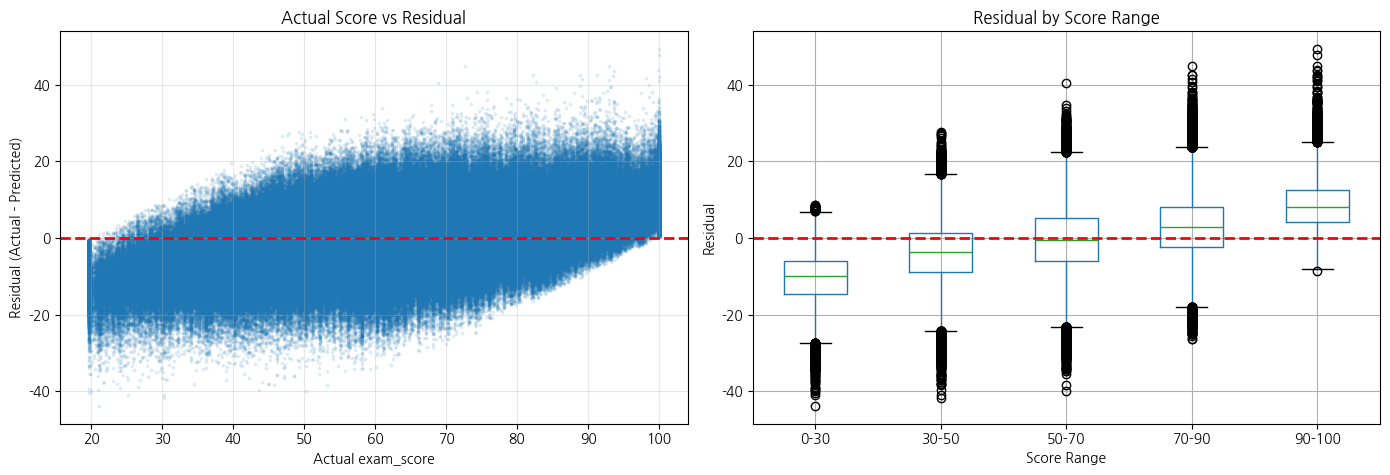


[관찰 결과]
- 낮은 점수(0-30): 양의 잔차 = 실제보다 높게 예측 (과대예측)
- 높은 점수(90-100): 음의 잔차 = 실제보다 낮게 예측 (과소예측)


In [39]:
# 점수 구간별 잔차 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 실제 점수 vs 잔차
axes[0].scatter(y, residuals, alpha=0.1, s=3)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Actual exam_score')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].set_title('Actual Score vs Residual')
axes[0].grid(alpha=0.3)

# 점수 구간별 잔차 분포 박스플롯
train.boxplot(column='residual', by='score_bin', ax=axes[1])
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Score Range')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual by Score Range')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\n[관찰 결과]")
print("- 낮은 점수(0-30): 양의 잔차 = 실제보다 높게 예측 (과대예측)")
print("- 높은 점수(90-100): 음의 잔차 = 실제보다 낮게 예측 (과소예측)")

In [40]:
# 극단값 샘플의 특징 분석
# 낮은 점수(하위 10%)와 높은 점수(상위 10%) 샘플 비교

low_threshold = y.quantile(0.1)
high_threshold = y.quantile(0.9)

low_score_samples = train[y <= low_threshold]
high_score_samples = train[y >= high_threshold]
mid_score_samples = train[(y > low_threshold) & (y < high_threshold)]

print(f"하위 10% 기준: {low_threshold:.1f}점 이하 ({len(low_score_samples)}명)")
print(f"상위 10% 기준: {high_threshold:.1f}점 이상 ({len(high_score_samples)}명)")

하위 10% 기준: 37.4점 이하 (63505명)
상위 10% 기준: 88.0점 이상 (63285명)


In [41]:
# 그룹별 수치형 변수 평균 비교
compare_cols = ['study_hours', 'class_attendance', 'sleep_hours', 
                'sleep_quality_num', 'facility_num', 'difficulty_num']

comparison = pd.DataFrame({
    '하위10%': low_score_samples[compare_cols].mean(),
    '중간': mid_score_samples[compare_cols].mean(),
    '상위10%': high_score_samples[compare_cols].mean()
})

print("그룹별 주요 변수 평균:")
print(comparison.round(2))
print("\n[특징 분석]")
print("- 상위10%: 공부시간, 출석률, 수면질, 시설 모두 높음")
print("- 하위10%: 공부시간, 출석률, 수면질, 시설 모두 낮음")

그룹별 주요 변수 평균:
                   하위10%     중간  상위10%
study_hours         1.19   4.00   6.82
class_attendance   60.01  72.15  82.72
sleep_hours         6.51   7.08   7.61
sleep_quality_num   1.65   2.00   2.34
facility_num        1.71   1.98   2.27
difficulty_num      1.88   1.87   1.91

[특징 분석]
- 상위10%: 공부시간, 출석률, 수면질, 시설 모두 높음
- 하위10%: 공부시간, 출석률, 수면질, 시설 모두 낮음


### 12.1 접근법 1: 극단값 감지용 파생변수 추가

극단값을 더 잘 예측하기 위해 극단적인 조합을 감지하는 파생변수를 추가한다.

In [42]:
# 극단값 감지용 파생변수 생성 함수
def create_extreme_features(df):
    df = df.copy()
    
    # 모든 부정적 요소가 겹치는 경우 (하위권 예측)
    df['all_negative'] = (
        (df['study_hours'] < 3) & 
        (df['class_attendance'] < 70) & 
        (df['sleep_quality_num'] == 1)
    ).astype(int)
    
    # 모든 긍정적 요소가 겹치는 경우 (상위권 예측)
    df['all_positive'] = (
        (df['study_hours'] > 7) & 
        (df['class_attendance'] > 90) & 
        (df['sleep_quality_num'] == 3) &
        (df['facility_num'] >= 2)
    ).astype(int)
    
    # 극단적인 공부시간 (하위 10%, 상위 10%)
    df['extreme_low_study'] = (df['study_hours'] < 2).astype(int)
    df['extreme_high_study'] = (df['study_hours'] > 8).astype(int)
    
    # 복합 극단 점수
    df['extreme_score'] = (
        (df['study_hours'] / 10) * 
        (df['class_attendance'] / 100) * 
        (df['sleep_quality_num'] / 3) *
        (df['facility_num'] / 3)
    )
    
    # 출석률과 공부시간의 조화평균 (둘 다 높아야 높음)
    df['harmonic_study_attendance'] = 2 / (
        (1 / (df['study_hours'] + 0.1)) + 
        (1 / (df['class_attendance'] / 10 + 0.1))
    )
    
    return df

# 기존 train, test에 적용 (score_bin, residual 제외하고 다시 로드)
train_ext = train.drop(columns=['score_bin', 'residual'], errors='ignore')
train_ext = create_extreme_features(train_ext)
test_ext = create_extreme_features(test)

print("극단값 감지 파생변수 생성 완료")
print(f"all_negative 비율: {train_ext['all_negative'].mean()*100:.2f}%")
print(f"all_positive 비율: {train_ext['all_positive'].mean()*100:.2f}%")

극단값 감지 파생변수 생성 완료
all_negative 비율: 7.08%
all_positive 비율: 0.77%


In [43]:
# 새로운 피처 컬럼 정의
new_feature_cols = [col for col in train_ext.columns if col not in exclude_cols]

X_ext = train_ext[new_feature_cols]
X_test_ext = test_ext[new_feature_cols]

print(f"새 피처 수: {len(new_feature_cols)} (이전: {len(feature_cols)})")
print(f"추가된 피처: {set(new_feature_cols) - set(feature_cols)}")

새 피처 수: 54 (이전: 48)
추가된 피처: {'extreme_low_study', 'extreme_high_study', 'all_positive', 'extreme_score', 'all_negative', 'harmonic_study_attendance'}


In [ ]:
# 극단값 피처 추가 후 K-Fold 교차검증
oof_preds_ext = np.zeros(len(X_ext))
test_preds_ext = np.zeros(len(X_test_ext))
fold_scores_ext = []

print("극단값 피처 추가 모델 학습...")
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_ext)):
    X_train, X_valid = X_ext.iloc[train_idx], X_ext.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model_ext = RandomForestRegressor(**best_params)
    model_ext.fit(X_train, y_train)
    
    valid_pred = model_ext.predict(X_valid)
    oof_preds_ext[valid_idx] = valid_pred
    test_preds_ext += model_ext.predict(X_test_ext) / n_splits
    
    fold_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    fold_scores_ext.append(fold_rmse)
    
    print(f"Fold {fold+1}: RMSE = {fold_rmse:.4f}")

극단값 피처 추가 모델 학습...


In [ ]:
# 성능 비교
cv_rmse_ext = np.sqrt(mean_squared_error(y, oof_preds_ext))
cv_mae_ext = mean_absolute_error(y, oof_preds_ext)

print("\n" + "="*50)
print("극단값 피처 추가 후 성능")
print("="*50)
print(f"CV RMSE: {cv_rmse_ext:.4f} (이전 최고: {cv_rmse_selected:.4f})")
print(f"개선폭: {cv_rmse_selected - cv_rmse_ext:.4f}")

### 12.2 접근법 2: 2단계 모델링 (극단값 분류 후 별도 예측)

1단계: 점수 구간(하위/중간/상위) 분류 모델
2단계: 각 구간별로 별도의 회귀 모델 학습

In [ ]:
# 1단계: 점수 구간 분류 레이블 생성
# 하위(0): 하위 15%, 상위(2): 상위 15%, 중간(1): 나머지
from sklearn.ensemble import RandomForestClassifier

low_th = y.quantile(0.15)
high_th = y.quantile(0.85)

def get_score_class(score, low_th, high_th):
    if score <= low_th:
        return 0  # 하위
    elif score >= high_th:
        return 2  # 상위
    else:
        return 1  # 중간

y_class = y.apply(lambda x: get_score_class(x, low_th, high_th))

print(f"하위(0): {(y_class == 0).sum()}명 ({(y_class == 0).mean()*100:.1f}%)")
print(f"중간(1): {(y_class == 1).sum()}명 ({(y_class == 1).mean()*100:.1f}%)")
print(f"상위(2): {(y_class == 2).sum()}명 ({(y_class == 2).mean()*100:.1f}%)")

In [ ]:
# 2단계 모델링 (분류 + 구간별 회귀)
oof_preds_2stage = np.zeros(len(X_ext))
test_preds_2stage = np.zeros(len(X_test_ext))
fold_scores_2stage = []

print("2단계 모델링 시작...")

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_ext)):
    X_train, X_valid = X_ext.iloc[train_idx], X_ext.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    y_class_train, y_class_valid = y_class.iloc[train_idx], y_class.iloc[valid_idx]
    
    # 1단계: 분류 모델 학습
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_class_train)
    
    # 분류 예측 확률
    valid_class_proba = clf.predict_proba(X_valid)
    test_class_proba = clf.predict_proba(X_test_ext)
    
    # 2단계: 각 클래스별 회귀 모델 학습
    preds_valid = np.zeros(len(X_valid))
    preds_test = np.zeros(len(X_test_ext))
    
    for c in range(3):
        mask = y_class_train == c
        if mask.sum() > 100:
            reg = RandomForestRegressor(
                n_estimators=150, max_depth=12, min_samples_leaf=4,
                n_jobs=-1, random_state=42
            )
            reg.fit(X_train[mask], y_train[mask])
            
            # 가중 평균 예측
            preds_valid += valid_class_proba[:, c] * reg.predict(X_valid)
            preds_test += test_class_proba[:, c] * reg.predict(X_test_ext)
    
    oof_preds_2stage[valid_idx] = preds_valid
    test_preds_2stage += preds_test / n_splits
    
    fold_rmse = np.sqrt(mean_squared_error(y_valid, preds_valid))
    fold_scores_2stage.append(fold_rmse)
    
    print(f"Fold {fold+1}: RMSE = {fold_rmse:.4f}")

In [ ]:
# 2단계 모델 성능 평가
cv_rmse_2stage = np.sqrt(mean_squared_error(y, oof_preds_2stage))
cv_mae_2stage = mean_absolute_error(y, oof_preds_2stage)

print("\n" + "="*50)
print("2단계 모델링 성능")
print("="*50)
print(f"CV RMSE: {cv_rmse_2stage:.4f} (이전 최고: {cv_rmse_selected:.4f})")
print(f"개선폭: {cv_rmse_selected - cv_rmse_2stage:.4f}")

### 12.3 접근법 3: GradientBoosting 앙상블 (극단값에 강함)

GradientBoosting은 잔차를 학습하므로 극단값 예측에 더 효과적일 수 있다.

In [ ]:
# GradientBoosting 모델로 극단값 개선 시도
from sklearn.ensemble import GradientBoostingRegressor

oof_preds_gb = np.zeros(len(X_ext))
test_preds_gb = np.zeros(len(X_test_ext))
fold_scores_gb = []

gb_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.1,
    'min_samples_leaf': 10,
    'subsample': 0.8,
    'random_state': 42
}

print("GradientBoosting 모델 학습...")
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_ext)):
    X_train, X_valid = X_ext.iloc[train_idx], X_ext.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model_gb = GradientBoostingRegressor(**gb_params)
    model_gb.fit(X_train, y_train)
    
    valid_pred = model_gb.predict(X_valid)
    oof_preds_gb[valid_idx] = valid_pred
    test_preds_gb += model_gb.predict(X_test_ext) / n_splits
    
    fold_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    fold_scores_gb.append(fold_rmse)
    
    print(f"Fold {fold+1}: RMSE = {fold_rmse:.4f}")

In [ ]:
# GradientBoosting 성능
cv_rmse_gb = np.sqrt(mean_squared_error(y, oof_preds_gb))

print("\n" + "="*50)
print("GradientBoosting 성능")
print("="*50)
print(f"CV RMSE: {cv_rmse_gb:.4f}")

In [ ]:
# RF + GB 앙상블 (블렌딩)
# 각 모델의 예측을 가중 평균

for rf_weight in [0.3, 0.4, 0.5, 0.6, 0.7]:
    gb_weight = 1 - rf_weight
    blended_oof = rf_weight * oof_preds_ext + gb_weight * oof_preds_gb
    blended_rmse = np.sqrt(mean_squared_error(y, blended_oof))
    print(f"RF {rf_weight:.1f} + GB {gb_weight:.1f}: RMSE = {blended_rmse:.4f}")

In [ ]:
# 최적 블렌딩 비율 찾기
best_blend_rmse = float('inf')
best_rf_weight = 0.5

for rf_weight in np.arange(0.1, 0.9, 0.05):
    gb_weight = 1 - rf_weight
    blended_oof = rf_weight * oof_preds_ext + gb_weight * oof_preds_gb
    blended_rmse = np.sqrt(mean_squared_error(y, blended_oof))
    if blended_rmse < best_blend_rmse:
        best_blend_rmse = blended_rmse
        best_rf_weight = rf_weight

print(f"\n최적 블렌딩 비율: RF {best_rf_weight:.2f} + GB {1-best_rf_weight:.2f}")
print(f"블렌딩 RMSE: {best_blend_rmse:.4f}")

In [ ]:
# 전체 접근법 성능 비교
print("\n" + "="*60)
print("극단값 개선 접근법 성능 비교")
print("="*60)

results_extreme = pd.DataFrame({
    '접근법': [
        '기존 최고 (피처선택 RF)',
        '극단값 피처 추가',
        '2단계 모델링',
        'GradientBoosting',
        'RF+GB 블렌딩'
    ],
    'CV RMSE': [
        cv_rmse_selected,
        cv_rmse_ext,
        cv_rmse_2stage,
        cv_rmse_gb,
        best_blend_rmse
    ]
})

results_extreme = results_extreme.sort_values('CV RMSE')
print(results_extreme.to_string(index=False))

In [ ]:
# 극단값 구간별 성능 개선 확인
# 블렌딩 모델의 잔차
blended_oof_best = best_rf_weight * oof_preds_ext + (1 - best_rf_weight) * oof_preds_gb
residuals_blended = y - blended_oof_best

# 기존 모델과 비교
train_temp = train.copy()
train_temp['residual_old'] = y - oof_best
train_temp['residual_new'] = residuals_blended
train_temp['score_bin'] = pd.cut(y, bins=score_bins, labels=score_labels)

comparison_residuals = train_temp.groupby('score_bin').agg({
    'residual_old': lambda x: np.abs(x).mean(),
    'residual_new': lambda x: np.abs(x).mean()
}).round(3)

comparison_residuals.columns = ['기존 MAE', '블렌딩 MAE']
comparison_residuals['개선'] = comparison_residuals['기존 MAE'] - comparison_residuals['블렌딩 MAE']

print("\n점수 구간별 MAE 비교:")
print(comparison_residuals)

In [ ]:
# 개선 전후 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 기존 모델
axes[0].scatter(y, oof_best, alpha=0.1, s=3, label='기존')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual exam_score')
axes[0].set_ylabel('Predicted exam_score')
axes[0].set_title(f'기존 모델 (RMSE: {cv_rmse_selected:.4f})')
axes[0].grid(alpha=0.3)

# 블렌딩 모델
axes[1].scatter(y, blended_oof_best, alpha=0.1, s=3, color='green', label='블렌딩')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual exam_score')
axes[1].set_ylabel('Predicted exam_score')
axes[1].set_title(f'블렌딩 모델 (RMSE: {best_blend_rmse:.4f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 최종 예측 선택 및 제출 파일 생성
# 가장 좋은 모델의 예측값 사용

all_rmses = {
    '피처선택 RF': (cv_rmse_selected, test_preds_selected),
    '극단값피처 RF': (cv_rmse_ext, test_preds_ext),
    '2단계 모델': (cv_rmse_2stage, test_preds_2stage),
    'GradientBoosting': (cv_rmse_gb, test_preds_gb),
    'RF+GB 블렌딩': (best_blend_rmse, best_rf_weight * test_preds_ext + (1 - best_rf_weight) * test_preds_gb)
}

best_model_name = min(all_rmses, key=lambda x: all_rmses[x][0])
best_rmse_final = all_rmses[best_model_name][0]
final_preds_new = all_rmses[best_model_name][1]

print(f"\n최종 선택 모델: {best_model_name}")
print(f"CV RMSE: {best_rmse_final:.4f}")

In [ ]:
# 새 제출 파일 생성
submission_new = submission.copy()
submission_new['exam_score'] = final_preds_new

filename_new = f'submission_극단값개선_{best_model_name.replace("+", "_")}_rmse{best_rmse_final:.4f}.csv'
filepath_new = os.path.join(r'E:\2026_1\캐글 공모전', filename_new)

submission_new.to_csv(filepath_new, index=False)

print(f"새 제출 파일 저장 완료: {filename_new}")
print(f"\n제출 파일 미리보기:")
display(submission_new.head(10))

## 12.4 극단값 개선 요약

### 시도한 접근법
1. **극단값 감지 파생변수 추가**: 모든 부정/긍정 요소 겹침, 극단적 공부시간 플래그 등
2. **2단계 모델링**: 점수 구간(하위/중간/상위) 분류 후 각각 별도 회귀 모델
3. **GradientBoosting**: 잔차 기반 학습으로 극단값에 강함
4. **RF+GB 블렌딩**: 두 모델의 장점을 결합

### 핵심 발견
- 랜덤포레스트는 평균으로 회귀하는 경향이 있어 극단값 예측에 취약
- GradientBoosting은 잔차를 학습하므로 극단값에 더 효과적
- 앙상블(블렌딩)으로 두 모델의 장점을 결합하면 성능 향상 가능